# 1 Data wrangling<a id='1_data_wrangling'></a>

In [1]:
# Import libraries
import os
import csv
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 1.1 Data Collection

In [2]:
# Raw data directory references
listings_dir = r'..\data\raw\listings'
metadata_dir = r'..\data\metadata'
core_fp = r'..\data\raw\core\LoanLevelMonthly_NEW_Core_20210101.csv'

In [3]:
# Get column headers for all raw data listing files
headers = {}
for fn in os.listdir(listings_dir):
    if fn.endswith(".csv"): 
        fp = os.path.join(listings_dir, fn)
        with open(fp, "r") as f:
            reader = csv.reader(f)
            headers[fn] = next(reader)
        continue
    else:
        continue

In [4]:
# Compare headers across all files
keys = list(headers.keys())
check = []
for i in range(0, len(keys)):
    for j in range(i+1, len(keys)):
        k1 = keys[i]
        k2 = keys[j]
        a = set(headers[k1])
        b = set(headers[k2])
        d = a.difference(b)
        if len(d) > 0:
            check.append(d)
            print((f"Inspect the headers for {k1} and {k2}!"))
if len(check) == 0:
    print((f"No header differences found!"))

No header differences found!


Since we are working with multiple raw listing files from 2005 to 2020 this validates that the structure of the data appears to be the same and can be merged.

### 1.1.1 Process Core Data File

The core data is a combination of historical listings and the current status (paid off or charge off).  For this project we will be working with the listings data since we will making predictions on new listings but in order to train the model we need to know the final status of th eloan.  The core fle is large (~33GB) so we will process the file in chunks and only extract out the fields needed to merge with listings.

In [5]:
# Turn off column/row truncation and preview the core file to get an idea of columns available
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df_preview = pd.read_csv(core_fp, nrows=20)
# Do not show unique identifiers in preview of core data since it is confidential
df_preview.drop(['LoanID', 'ListingNumber'], axis=1).head(20)

,LoanAmount,ProsperRating,Term,LoanProductID,ListingCategoryName,LenderRate,BorrowerRateAtOrigination,BorrowerRate,MnthRateAtOrigination,MnthRate,BorrowerDTIAtOrigination,EstimatedAnnualizedLossRateAtOrigination,EstimatedReturnAtOrigination,FICORange,ScorexRange,HasPriorLoanFlag,OriginationDate,OriginationQuarter,OrigMID,StatedMaturityDate,ScheduledMonthlyPaymentAmount,DefaultMonth,DefaultAmount,ChargeoffMonth,ChargeoffAmount,CompletedMonth,MonthofLastPayment,DebtSaleMonth,GrossCashFromDebtSale,DebtSaleFee,NetCashToInvestorsFromDebtSale,SettlementStartDate,SettlementEndDate,SettlementStatus,SettlementBalAtEnrollment,SettlementAgreedPmtAmt,SettlementFirstPmtDueDate,ExtensionExecutionDate,ExtensionStatus,ExtensionTerm,CancelledMonth,ObservationMonth,CycleCounter,ExplicitRoll,ExplicitRoll_EOM,SummaryRoll,SummaryRoll_EOM,DaysPastDue,PriorMonthDPD,DaysPastDue_EOM,PriorMonthDPD_EOM,PaymentsReceived,CollectionFees,PrincipalPaid,InterestPaid,LateFees,ServicingFees,RecoveryPayments,RecoveryPrin,PrinAdjustments,LastMonthCatchUpPrin,PeriodicPrepayPrin,CumulPrin,CumulPrinAdjusted,CumulCustBal,CumulInt,CumulServFees,CumulLateFees,CumulCollectFees,CumulCO,CumulBK,BOMPrin,BOMPrinAdjusted,EOMPrin,EOMPrinAdjusted,BOMPrinCust,EOMPrinCust,AvgPrinCust,MargPrinCO,MargPrinBK,LastPaymentMadeDt,LastPaymentDisbursedDt,ScheduledPrinRemaining,ScheduledCumulPrin,ScheduledPeriodicPrin,InvestmentProductID
0,8000,AA,36,1,Debt Consolidation,0.000431,0.0531,0.0531,0.004425,0.00443,0.11,0.0074,NaN,720-739,NaN,0,2018-03-05,Q1 2018,201803,202103,240.88,NaN,0,NaN,0.00,201807.0,201807.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,201908,17,PreviouslyPaidOff,PreviouslyPaidOff,NoChange,NoChange,0,0,0,0,0.00,0,0.00,0.00,0,0.00,0,0,0,0.0000,0.0000,8000.00,8000.00,38456.060,145.93,-29.54,0,0,0.00,0,0.00,0.00,0.00,0.00,0.00,0.00,0.000,0,0,2018-07-14 00:00:00,2018-07-16 00:00:00,4380.9620,3619.0380,220.4957,1
1,8000,AA,36,1,Debt Consolidation,0.000431,0.0531,0.0531,0.004425,0.00443,0.29,0.0074,NaN,760-779,NaN,0,2018-03-05,Q1 2018,201803,202103,240.88,NaN,0,NaN,0.00,201805.0,201805.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,201908,17,PreviouslyPaidOff,PreviouslyPaidOff,NoChange,NoChange,0,0,0,0,0.00,0,0.00,0.00,0,0.00,0,0,0,0.0000,0.0000,8000.00,8000.00,19850.625,55.07,-11.15,0,0,0.00,0,0.00,0.00,0.00,0.00,0.00,0.00,0.000,0,0,2018-05-01 00:00:00,2018-05-02 00:00:00,4380.9620,3619.0380,220.4957,1
2,10000,AA,36,1,Debt Consolidation,0.000431,0.0531,0.0531,0.004425,0.00443,0.12,0.0074,NaN,760-779,NaN,0,2018-03-07,Q1 2018,201803,202103,301.10,NaN,0,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,201908,17,No Change,No Change,NoChange,NoChange,0,0,0,0,295.85,0,275.16,25.94,0,-5.25,0,0,0,0.2579,0.0000,4523.08,4523.08,142043.430,595.62,-120.59,0,0,0.00,0,5752.08,5752.08,5476.92,5476.92,5752.08,5476.92,5614.500,0,0,2019-08-07 00:00:00,2019-08-09 00:00:00,5476.2025,4523.7975,275.6196,1
3,14000,AA,36,1,Debt Consolidation,0.000431,0.0531,0.0531,0.004425,0.00443,0.34,0.0074,NaN,740-759,NaN,0,2018-03-07,Q1 2018,201803,202103,421.54,NaN,0,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,201908,17,No Change,No Change,NoChange,NoChange,0,0,0,0,414.19,0,385.22,36.32,0,-7.35,0,0,0,0.3590,0.0000,6332.31,6332.31,198860.815,833.87,-168.81,0,0,0.00,0,8052.91,8052.91,7667.69,7667.69,8052.91,7667.69,7860.300,0,0,2019-08-07 00:00:00,2019-08-09 00:00:00,7666.6835,6333.3165,385.8675,1
4,7000,AA,36,1,Medical / Dental,0.000431,0.0531,0.0531,0.004425,0.00443,0.09,0.0074,NaN,760-779,NaN,0,2018-02-06,Q1 2018,201802,202102,210.77,NaN,0,NaN,0.00,202002.0,202002.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,201911,21,No Change,No Change,NoChange,NoChange,0,0,0,0,209.80,0,205.99,4.78,0,-0.97,0,0,0,0.0000,9.6148,6145.53,6145.53,84555.355,359.10,-72.71,0,0,0.00,0,1060.46,1060.46,854.47,854.47,1060.46,854.47,957.465,0,0,2019-11-06 00:00:00,2019-11-07 00:00:00,3053.0225,3946.9775,196.3752,1
5,9500,AA,36,1,Debt Consolidation,0

In [6]:
# Create function to preprocess each chunk from the core data
def chunk_core_preprocessing(chunk):
    # Create binary charge off
    chunk['chargeoff'] = chunk['ChargeoffAmount'].apply(lambda x: 1 if x > 0 else 0).astype('int8')
    # Create binary paid off
    chunk['paidoff'] = chunk['CompletedMonth'].apply(lambda x: 0 if pd.isnull(x) else 1).astype('int8')
    # Combine month field into 1 for closed loans (paid or charged off)
    chunk['closed_month'] = chunk['ChargeoffMonth']
    chunk['closed_month'].fillna(chunk['CompletedMonth'], inplace=True)
    # Fill blanks with zero
    chunk['NetCashToInvestorsFromDebtSale'].fillna(0, inplace=True)
    # Filter only paid or charged off loans
    chunk_out = chunk.loc[(chunk['chargeoff'] == 1) | (chunk['paidoff'] == 1)]
    return chunk_out

In [7]:
# Dict to hold rename mapping and dtypes
core_dict = {'LoanID': ('loan_id', 'int64'), 
           'ListingNumber': ('listing_number', 'int64'), 
           'OrigMID': ('origination_month', 'float32'),
           'ChargeoffMonth': ('chargeoff_month', 'float32'),
           'ChargeoffAmount': ('chargeoff_amount', 'float32'), 
           'CompletedMonth': ('completed_month', 'float32'),
            'ObservationMonth': ('observation_month', 'float32'),
            'CumulPrin': ('principal_paid', 'float32'),
            'CumulInt': ('interest_paid', 'float32'),
            'NetCashToInvestorsFromDebtSale': ('debt_sale_recovery', 'float32')
            }
# Create list to store processed chunks
chunks_processed = []
# Create chunks from core file in 500,000 row chunks
chunks = pd.read_csv(core_fp, usecols=list(core_dict.keys()), dtype={k: v[1] for k, v in core_dict.items()},
                     chunksize=500000)
# Iterate over chunks
for chunk in chunks:
    chunks_processed.append(chunk_core_preprocessing(chunk))
# Combine all chunks
df_core = pd.concat(chunks_processed)
# Rename columns to be consistent with listings/api fields
df_core = df_core.rename({k: v[0] for k, v in core_dict.items()}, axis=1)
# Sort by observation_month for duplicate removal
df_core = df_core.sort_values(by='observation_month', ascending=False)
# Remove duplicates
df_core = df_core.drop_duplicates(subset='listing_number', keep='first')
# Drop chargeoff_month/completed_month since it is reflected in closed_month and no longer need observation_month
df_core = df_core.drop(['completed_month', 'chargeoff_month', 'observation_month'], axis=1)
# Set ListingNumber as index
df_core = df_core.set_index('listing_number')
# Review output
df_core.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1019870 entries, 4226262 to 18
Data columns (total 9 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   loan_id             1019870 non-null  int64  
 1   origination_month   1019870 non-null  float32
 2   chargeoff_amount    1019870 non-null  float32
 3   debt_sale_recovery  1019870 non-null  float32
 4   principal_paid      1019870 non-null  float32
 5   interest_paid       1019870 non-null  float32
 6   chargeoff           1019870 non-null  int8   
 7   paidoff             1019870 non-null  int8   
 8   closed_month        1019870 non-null  float32
dtypes: float32(6), int64(1), int8(2)
memory usage: 40.9 MB


The final memory usage for the filtered core data is only 41MB!

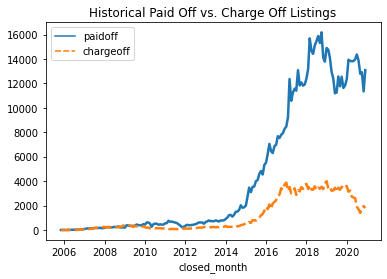

In [8]:
# Plot closed loans to get an idea on potential timeframe filters
df_core_grouped = df_core.groupby('closed_month').sum()[['paidoff', 'chargeoff']]
df_core_grouped.index = pd.to_datetime(df_core_grouped.index.astype(int), format='%Y%m')
sns.lineplot(data=df_core_grouped, palette="tab10", linewidth=2.5)
plt.title('Historical Paid Off vs. Charge Off Listings')
plt.show()

As the historical closed loans data shows, Prosper had some challenges early on.  According to the [Prosper Marketplace Wikipedia](https://en.wikipedia.org/wiki/Prosper_Marketplace), Prosper received a cease and desist order from the SEC in November 2008 and they subsequently shut down.  Prosper reopened in July 2009 and it took approximately 5 years until 2014 until they started to see divergence of paid off to charge off loans.  For this project we will focus on the last 3 years of closed loans 2018 to 2020.

In [9]:
df_core_filtered = df_core.loc[(df_core['closed_month'] >= 201801) & (df_core['closed_month'] <= 202012)].copy()
df_core_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 599672 entries, 4226262 to 2261862
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   loan_id             599672 non-null  int64  
 1   origination_month   599672 non-null  float32
 2   chargeoff_amount    599672 non-null  float32
 3   debt_sale_recovery  599672 non-null  float32
 4   principal_paid      599672 non-null  float32
 5   interest_paid       599672 non-null  float32
 6   chargeoff           599672 non-null  int8   
 7   paidoff             599672 non-null  int8   
 8   closed_month        599672 non-null  float32
dtypes: float32(6), int64(1), int8(2)
memory usage: 24.0 MB


### 1.1.2 Listings Metadata File

This spreadsheet was created to combine all of the columns from the listing files and cross-reference to the [Prosper Investor API Overview](https://developers.prosper.com/docs/investor/) resource to indicate if the column is available in the API as well as flagging which fields are Experian or Transunion credit bureau data.  The number of columns in the listing files is large so judgment was used to exclude columns to limit the size of the data and pare down columns for analysis.  For example, the `credit_pull_date` column indicates when the credit profile was pulled for the listing and this really should not be relevent for modeling purposes.

In [10]:
# Create metadata reference dataframe
metadata = pd.read_excel(os.path.join(metadata_dir, 'listings_dictionary.xlsx'))
metadata = metadata.set_index('Name')
metadata.head()

,Order,Description,Type,Rename,API,Include,Experian,Transunion,Notes
Name,,,,,,,,,
member_key,1,Borrower unique ID/Member key,object,NaN,1,0,0,0,NaN
listing_number,2,Listing Number as found on the Prosper site,Int64,NaN,1,1,0,0,NaN
credit_pull_date,3,Date the Credit profile was pulled for the lis...,object,NaN,0,0,0,0,NaN
listing_start_date,4,Listing Start Date date format 'yyyy-MM-dd',object,NaN,1,0,0,0,Not relevant to historical performance
listing_end_date,5,Listing End Date date format 'yyyy-MM-dd',object,NaN,1,0,0,0,Not relevant to historical performance


### 1.1.3 Match Credit Bureau Columns

Per the listings API, Prosper switched from using Experian credit underwriting data to using TransUnion credit underwriting data to generate loan offers on 3/31/2017. After this date, all new listings contain only TransUnion credit bureau data.  **All** Experian and Transunion columns are provided in the listings file but the Experian columns will be blank for recent listings.  

Since we will only have the Transunion credit bureau data on new listings this means we will have to attempt to match Experian columns to Transunion columns so we don't lose valuable credit bureau data on historical listings.  The information we have is the name of the column and a brief description.

In [11]:
# Isolate Experian and Transunion columns
exp = metadata['Description'][metadata['Experian'] == 1] 
tu = metadata['Description'][metadata['Transunion'] == 1]

##### 1.1.3.1 fuzzywuzzy matching

In [12]:
from fuzzywuzzy import process
s1 = 'Total number of trades'
matches1 = process.extract(s1, tu, limit = 5)
matches1

[('Number of trades', 95, 'AT01S'),
 ('Number of open trades currently satisfactory', 86, 'AT03S'),
 ('Number of trades opened in past 6 months', 86, 'AT06S'),
 ('Number of trades opened in past 24 months', 86, 'AT09S'),
 ('Number of open trades verified in past 12 months', 86, 'AT12S')]

Transunion field AT01S is a pretty close match for the Experian column "Total number of trades" and is the highest scored match.  Great but let's try a more complex example.

In [13]:
s2 = 'Total number of trades 30 or more days delinquent or derogatory in the last 12 months'
matches2 = process.extract(s2, tu, limit = 5)
matches2

[('Number of trades', 90, 'AT01S'),
 ('Number of open trades', 86, 'AT02S'),
 ('Number of open trades currently satisfactory', 86, 'AT03S'),
 ('Number of trades opened in past 6 months', 86, 'AT06S'),
 ('Number of trades opened in past 24 months', 86, 'AT09S')]

In this example, fuzzywuzzy did not find a relevant match but manual review of the Transunion columns we know there is a match G059S: Total number of trades 30 or more days delinquent or derogatory in the last 12 months.  Let's try the gensim pre-trained word vector model to see if we can get matches.

##### 1.1.3.2 gensim word vector model

In [14]:
# Import gensim
import gensim.downloader as api
# load pre-trained word-vectors from gensim-data
word_vectors = api.load("glove-wiki-gigaword-100")

In [15]:
# Split test string 2
a = s2.lower().split()
for i, choice in tu.iteritems():
    b = choice.lower().split()
    similarity = word_vectors.wmdistance(a, b)
    # Only capture results with similarity score <= 2
    if similarity <= 2:
        print((s2, choice, similarity))

('Total number of trades 30 or more days delinquent or derogatory in the last 12 months', 'Number of trades 30 or more days past due in past 12 months', 1.9162050920057778)


The gensim model did a much better job finding a match for the 2nd example.  Let's try the 1st example.

In [16]:
# Split test string 2
a = s1.lower().split()
for i, choice in tu.iteritems():
    b = choice.lower().split()
    similarity = word_vectors.wmdistance(a, b)
    # Only capture results with similarity score <= 2
    if similarity <= 2:
        print((s1, choice, similarity))

('Total number of trades', 'Number of trades', 1.3686731843576436)
('Total number of trades', 'Number of open trades', 1.651205475838065)
('Total number of trades', 'Number of auto trades', 1.791758824570656)
('Total number of trades', 'Number of charged-off trades', 1.3686731843576436)
('Total number of trades', 'Number of installment trades', 1.6488132726252078)
('Total number of trades', 'Number of mortgage trades', 1.9140419960021973)
('Total number of trades', 'Number of revolving trades', 1.687442843591094)
('Total number of trades', 'Number of retail trades', 1.6056576022578477)


We are getting multiple matches with a similarity score <= 2 so some human judgment will have to be used to decide which column is the best match.  For example, the Experian column "Total number of trades" is for all trades so AT01S "Number of trades" is the best match.  Now we will run this matching process on all Experian fields.

In [17]:
match_fn = 'experian_field_matches.csv'
rerun = False
if rerun:

    # List to store similary results
    results = []
    for i, field in exp.iteritems():
        a = field.lower().split()
        for j, choice in tu.iteritems():
            b = choice.lower().split()
            similarity = word_vectors.wmdistance(a, b)
            # Only capture results with similarity score <= 2
            if similarity <= 2:
                results.append((i, field, j, choice, similarity))
    matches = pd.DataFrame(results, columns=['Field', 'Description', 'Match', 'Match Description', 'Similarity'])
    matches = matches.sort_values(['Field', 'Similarity'])
    # Save results for reference
    matches.to_csv(os.path.join(metadata_dir, match_fn))
else:
    matches = pd.read_csv(os.path.join(metadata_dir, match_fn), index_col=0)

# Preview results
matches.head()

,Field,Description,Match,Match Description,Similarity
57,ale001,Total number of auto or auto lease trades,AU01S,Number of auto trades,1.945855
0,all001,Total number of trades,AT01S,Number of trades,1.368673
3,all001,Total number of trades,CO01S,Number of charged-off trades,1.368673
7,all001,Total number of trades,RT01S,Number of retail trades,1.605658
4,all001,Total number of trades,IN01S,Number of installment trades,1.648813


At this point the output file was reviewed and then the final credit bureau matches were stored in a json file.

In [18]:
# Load credit bureau field matches
cb_field_match_fn = 'credit_bureau_field_match.json'
with open(os.path.join(metadata_dir, cb_field_match_fn)) as f:
          cb_field_match = json.load(f)
cb_field_match

{'all001': 'AT01S',
 'all003': 'AT02S',
 'all081': 'G043S',
 'all106': 'G059S',
 'all124': 'G063S',
 'all127': 'G061S',
 'all141': 'G093S',
 'all790': 'S207S',
 'all805': 'G103S',
 'heq001': 'HI01S',
 'iln023': 'IN09S',
 'iln702': 'IN21S',
 'ref001': 'MT01S',
 'rev001': 'RE01S',
 'rev702': 'RE21S',
 'rtl001': 'RT01S',
 'all075': 'G041S',
 'all078': 'G042S',
 'all104': 'G058S',
 'all114': 'G068S',
 'all115': 'G069S',
 'all117': 'G020S',
 'all125': 'G064S',
 'all128': 'G066S',
 'all129': 'G071S',
 'aut001': 'AU01S',
 'cru001': 'OF01S',
 'iln001': 'IN01S'}

### 1.1.4 Process Listing Files

In [19]:
# Create final combined column list
include_cols = list(metadata.index[(metadata['Include'] == 1)])
exp_cols = list(cb_field_match.keys())
tu_cols = list(cb_field_match.values())
final_cols = [*include_cols, *exp_cols, *tu_cols]

In [20]:
# Create dictionary for dtypes
dt = {i[0]: i[1] for i in metadata['Type'][metadata.index.isin(final_cols)].items()}
dt

{'listing_number': 'Int64',
 'listing_creation_date': 'object',
 'loan_origination_date': 'object',
 'listing_status': 'Int16',
 'listing_amount': 'float32',
 'prosper_rating': 'object',
 'lender_yield': 'float32',
 'borrower_rate': 'float32',
 'borrower_apr': 'float32',
 'listing_term': 'Int16',
 'listing_monthly_payment': 'float32',
 'fico_score': 'object',
 'prosper_score': 'Int16',
 'income_range': 'Int16',
 'stated_monthly_income': 'float32',
 'income_verifiable': 'object',
 'employment_status_description': 'object',
 'occupation': 'object',
 'months_employed': 'Int32',
 'borrower_state': 'object',
 'prior_prosper_loans_active': 'float32',
 'prior_prosper_loans': 'float32',
 'prior_prosper_loans_principal_borrowed': 'float32',
 'prior_prosper_loans_principal_outstanding': 'float32',
 'prior_prosper_loans_balance_outstanding': 'float32',
 'prior_prosper_loans_cycles_billed': 'float32',
 'prior_prosper_loans_ontime_payments': 'float32',
 'prior_prosper_loans_late_cycles': 'float32',

All data types have been specified prior to processing listing files to conserve memory usage.

In [21]:
# Create function to preprocess each chunk from the listings data
def chunk_listings_preprocessing(chunk, core):
    # Iterate over credit bureau matches and replace Transunion blanks with Experian
    for k, v in cb_field_match.items():
        chunk[v] = chunk[v].fillna(chunk[k])
    # Drop credit bureau columns after filling
    chunk = chunk.drop(labels=list(cb_field_match.keys()), errors='ignore', axis=1)
    chunk_out = core.merge(chunk, how='inner', left_index=True, right_index=True)
    return chunk_out

In [22]:
# Create list to store processed chunks
chunks_processed = []
date_cols = [k for k, v in dt.items() if 'date' in k] 
for fn in os.listdir(listings_dir):
    if fn.endswith('.csv'): 
        fp = os.path.join(listings_dir, fn)
        # Create chunks from core file in 500,000 row chunks
        chunks = pd.read_csv(fp, usecols=final_cols, index_col='listing_number', dtype=dt, parse_dates=date_cols,
                             chunksize=500000)
        # Iterate over chunks
        for chunk in chunks:
            chunks_processed.append(chunk_listings_preprocessing(chunk, df_core_filtered))
    print(f'Processed {fn}!')
# Combine all chunks
df_listings = pd.concat(chunks_processed)
# Rename columns to match API field names
df_listings = df_listings.rename({i[0]: i[1] for i in metadata['Rename'][~metadata['Rename'].isna()].items()}, axis=1)

Processed Listings_20050101to20130101_20210114T163603.csv!
Processed Listings_20130101to20140101_20210114T164456.csv!
Processed Listings_20140101to20150101_20210114T164707.csv!
Processed Listings_20150101to20160101_20210114T165238.csv!
Processed Listings_20160101to20170101_20210114T170129.csv!
Processed Listings_20170101to20180101_20210114T170731.csv!
Processed Listings_20180101to20190101_20210114T172705.csv!
Processed Listings_20190101to20200101_20210114T174218.csv!
Processed Listings_20200101to20210101_20210123T060003.csv!


## 1.2 Data Definition

In [23]:
# Review columns and size
df_listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 585087 entries, 678465 to 11868936
Data columns (total 75 columns):
 #   Column                                            Non-Null Count   Dtype         
---  ------                                            --------------   -----         
 0   loan_id                                           585087 non-null  int64         
 1   origination_month                                 585087 non-null  float32       
 2   chargeoff_amount                                  585087 non-null  float32       
 3   debt_sale_recovery                                585087 non-null  float32       
 4   principal_paid                                    585087 non-null  float32       
 5   interest_paid                                     585087 non-null  float32       
 6   chargeoff                                         585087 non-null  int8          
 7   paidoff                                           585087 non-null  int8          
 8   closed_

The `loan_id` will not have any value on new listings so will be dropped.

The `chargeoff` field is the target variable but we will no longer need the `paidoff` field so that will be dropped now.

In [24]:
df_listings = df_listings.drop(['loan_id', 'paidoff'], errors='ignore', axis=1)

In [25]:
df_listings.describe()

,origination_month,chargeoff_amount,debt_sale_recovery,principal_paid,interest_paid,chargeoff,closed_month,listing_status,listing_amount,lender_yield,borrower_rate,borrower_apr,listing_term,listing_monthly_payment,prosper_score,income_range,stated_monthly_income,months_employed,prior_prosper_loans_active,prior_prosper_loans,prior_prosper_loans_principal_borrowed,prior_prosper_loans_principal_outstanding,prior_prosper_loans_balance_outstanding,prior_prosper_loans_cycles_billed,prior_prosper_loans_ontime_payments,prior_prosper_loans_late_cycles,prior_prosper_loans_late_payments_one_month_plus,max_prior_prosper_loan,min_prior_prosper_loan,prior_prosper_loan_earliest_pay_off,prior_prosper_loans31dpd,prior_prosper_loans61dpd,lender_indicator,AT01S,AT02S,AU01S,G020S,G041S,G042S,G043S,G058S,G059S,G061S,G063S,G064S,G066S,G068S,G069S,G071S,G093S,G103S,HI01S,IN01S,IN09S,IN21S,MT01S,OF01S,RE01S,RE21S,RT01S,S207S,dti_wprosper_loan,combined_dti_wprosper_loan,combined_stated_monthly_income
count,585087.000000,585087.000000,585087.000000,585087.000000,585087.000000,585087.000000,585087.000000,585087.000000,585087.000000,585087.000000,585087.000000,585087.000000,585087.000000,585087.000000,581553.000000,585087.000000,5.850870e+05,583820.000000,585087.000000,585087.000000,143139.000000,143139.000000,143139.000000,143139.00000,143139.000000,143139.000000,143139.000000,142618.000000,142618.000000,63738.000000,554.000000,199.000000,585087.000000,584894.000000,584871.000000,584823.000000,584823.000000,584823.000000,584823.000000,584894.000000,584871.000000,584871.000000,584871.000000,584823.000000,584871.000000,584871.000000,584823.000000,584823.000000,584823.000000,584894.000000,584823.000000,584871.000000,584871.000000,584871.000000,584823.000000,584894.000000,584823.000000,584822.000000,584822.000000,584822.000000,584869.000000,585087.000000,130.000000,130.000000
mean,201682.093750,1681.831299,166.823029,11689.871094,2746.060059,0.184947,201900.000000,6.000164,13358.516602,0.143573,0.153573,0.184575,42.549836,412.700348,7.181251,4.295594,6.955815e+03,112.312559,0.194152,0.384338,20960.623047,7309.773438,1418.737427,8.29667,7.356297,0.347005,0.075081,13938.431641,12234.439453,14.144984,1.064982,1.045226,0.009802,22.567356,11.277612,2.841479,9.418747,1.640493,1.077822,0.932350,0.073250,0.140658,0.367001,0.048495,0.081623,0.204030,0.046274,0.075407,0.178707,0.228558,303.294952,0.098069,7.262615,1.517962,229.708038,1.410343,1.486793,13.618802,13.222165,5.193702,3866.905762,8699.812500,0.228025,12933.311523
std,138.063797,4545.924316,508.470306,8284.963867,2543.976807,0.388255,82.010078,0.027172,8076.008301,0.068564,0.068564,0.072602,10.690927,242.224655,2.512629,1.168830,1.337459e+05,138.272715,0.978323,1.371141,40961.496094,27677.763672,4024.244873,36.63176,24.874012,4.794497,1.689330,8056.943359,7725.471191,10.188147,0.246717,0.208324,0.098519,12.087972,5.817068,2.595054,9.739706,2.544931,2.152208,2.027446,0.328529,0.489264,0.973970,0.278584,0.389863,0.768144,0.272948,0.377694,0.727068,0.632762,1696.860596,0.365584,6.712600,1.656371,1427.248291,1.683703,2.736024,8.163445,30.695169,4.527761,4864.256836,92864.898438,0.113888,5892.799805
min,201205.000000,0.000000,0.000000,0.000000,0.000000,0.000000,201801.000000,2.000000,2000.000000,0.043100,0.053100,0.056500,36.000000,40.070000,1.000000,1.000000,0.000000e+00,-7.000000,0.000000,0.000000,1000.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1000.000000,1000.000000,0.000000,1.000000,1.000000,0.000000,0.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,0.000000,-4.000000,-4.000000,-4.000000,-5.000000,-5.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,0.000000,0.028600,4416.666504
25%,201601.000000,0.000000,0.000000,5000.000000,979.125000,0.000000,201809.000000,6.000000,7500.000000,0.090900,0.100900,0.132660,36.000000,235.369995,5.000000,3.000000,3.750000e+03,29.00000

`prosper_score` has 3,534 blanks.  This is a custom risk score built using historical Prosper data. The score ranges from 1 to 11, 11 having the lowest risk.  Since this field will most likely be valuable for modeling purposes and the number of blanks is low will replace with zero so they can be identified in EDA.

`months_employed` has 1,267 blanks.  These will be replaced with the median.

The `prior_prosper_` fields have many blanks but this is assumed to be due to the fact not all borrowers would have a prior loan with prosper.  These will be replaced with zero.

The `combined_dti_wprosper_loan` and `combined_stated_monthly_income` fields are ~99.9% blank and will be dropped.

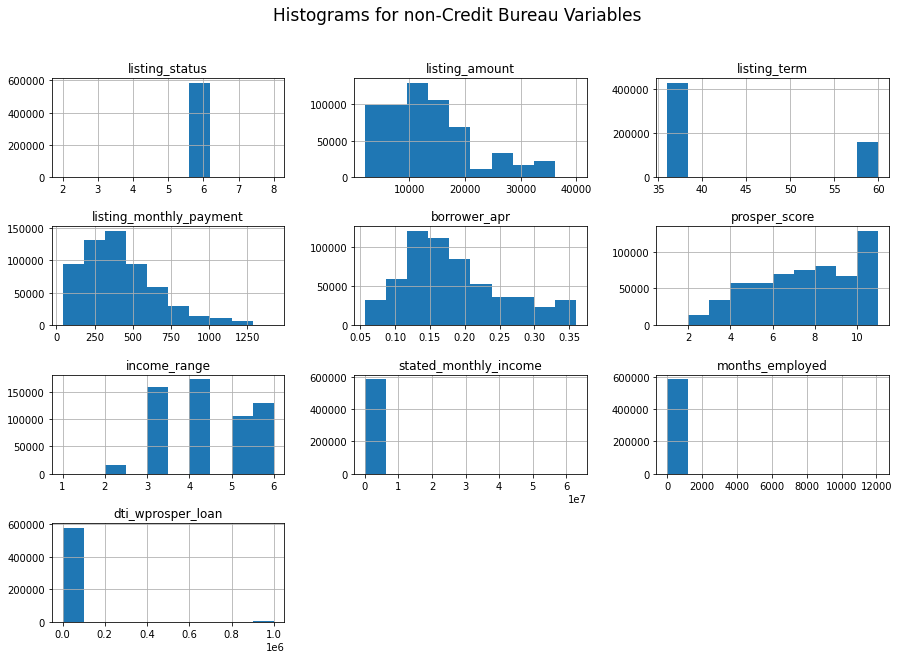

In [26]:
df_listings[['listing_status', 'listing_amount', 'listing_term', 'listing_monthly_payment', 'borrower_apr', 
             'prosper_score', 'income_range', 'stated_monthly_income', 'months_employed', 
             'dti_wprosper_loan']].hist(figsize=(15, 10))
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Histograms for non-Credit Bureau Variables', size=17)
plt.show()

The valid `listing_status` values are:

2 = Active – the listing is active on Prosper<br /> 
4 = Withdrawn – the listing was withdrawn by customer request<br />
5 = Expired – the listing failed to fund in time<br />
6 = Completed – the listing ran to completion and was funded<br />
7 = Cancelled – the listing was cancelled by Prosper<br />
8 = Pending Review/ Acceptance – the listing ran to completion but is awaiting listing review from Prosper or acceptance by the borrower<br />

Since we should only have listings that completed and funded the values for 2 and 8 appear to be anomalies in the listing files. 

In [27]:
# Review non-complete listing counts
df_listings['listing_status'][df_listings['listing_status'] != 6].value_counts()

8    68
2    10
Name: listing_status, dtype: Int64

In [28]:
# Review all rows
df_listings[df_listings['listing_status'] != 6].reset_index().drop(['listing_number'], axis=1)

,origination_month,chargeoff_amount,debt_sale_recovery,principal_paid,interest_paid,chargeoff,closed_month,listing_creation_date,loan_origination_date,listing_status,listing_amount,prosper_rating,lender_yield,borrower_rate,borrower_apr,listing_term,listing_monthly_payment,fico_score,prosper_score,income_range,stated_monthly_income,income_verifiable,employment_status_description,occupation,months_employed,borrower_state,prior_prosper_loans_active,prior_prosper_loans,prior_prosper_loans_principal_borrowed,prior_prosper_loans_principal_outstanding,prior_prosper_loans_balance_outstanding,prior_prosper_loans_cycles_billed,prior_prosper_loans_ontime_payments,prior_prosper_loans_late_cycles,prior_prosper_loans_late_payments_one_month_plus,max_prior_prosper_loan,min_prior_prosper_loan,prior_prosper_loan_earliest_pay_off,prior_prosper_loans31dpd,prior_prosper_loans61dpd,lender_indicator,AT01S,AT02S,AU01S,G020S,G041S,G042S,G043S,G058S,G059S,G061S,G063S,G064S,G066S,G068S,G069S,G071S,G093S,G103S,HI01S,IN01S,IN09S,IN21S,MT01S,OF01S,RE01S,RE21S,RT01S,S207S,dti_wprosper_loan,co_borrower_application,combined_dti_wprosper_loan,combined_stated_monthly_income
0,201810.0,7578.399902,1008.609985,1421.599976,1534.800049,1,201910.0,2018-09-11 06:44:08.507,NaT,8,9000.0,D,0.2644,0.27440,0.31400,36,369.549988,NaN,3,4,5546.666504,True,Employed,Professional,163,FL,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,17.0,14.0,5.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,6.0,1.0,4.0,0.0,2.0,11.0,19.0,0.0,-4.0,0.34,False,NaN,NaN
1,201810.0,0.000000,0.000000,13500.000000,976.619995,0,202002.0,2018-09-15 17:42:15.780,NaT,2,13500.0,AA,0.0744,0.08440,0.10884,36,425.790009,NaN,11,3,3234.333252,True,Employed,Laborer,48,FL,0.0,2.0,25000.0,0.000000,0.0,2.0,2.0,0.0,0.0,15000.0,10000.0,6.0,NaN,NaN,0,25.0,12.0,3.0,17.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,5.0,1.0,6.0,2.0,4.0,18.0,8.0,2.0,-4.0,0.16,False,NaN,NaN
2,201810.0,0.000000,0.000000,25000.000000,4668.669922,0,202010.0,2018-09-18 05:14:35.817,NaT,8,25000.0,B,0.1214,0.13140,0.16770,36,844.039978,NaN,5,6,10000.000000,True,Employed,Construction,3,NV,1.0,2.0,15000.0,378.540009,0.0,5.0,5.0,0.0,0.0,10000.0,5000.0,NaN,NaN,NaN,1,41.0,27.0,9.0,35.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.0,3.0,9.0,2.0,1.0,27.0,1.0,7.0,-4.0,0.49,False,NaN,NaN
3,201810.0,0.000000,0.000000,10000.000000,1770.310059,0,202001.0,2018-09-21 11:34:37.703,NaT,8,10000.0,C,0.1508,0.16080,0.19780,36,351.970001,NaN,3,4,5833.333496,True,Employed,Teacher,361,OH,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,21.0,14.0,2.0,18.0,4.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,12.0,0.0,3.0,1.0,24.0,3.0,1.0,15.0,5.0,7.0,-4.0,0.21,False,NaN,NaN
4,201810.0,0.000000,0.000000,8000.000000,1114.010010,0,202007.0,2018-09-22 14:18:44.813,NaT,2,8000.0,A,0.0954,0.10540,0.14114,36,260.170013,NaN,8,3,2500.000000,True,Employed,Other,31,PA,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,14.0,13.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,0.0,0.0,14.0,1.0,6.0,-4.0,0.15,False,NaN,NaN
5,201809.0,0.000000,0.000000,35000.000000,5630.279785,0,202012.0,2018-09-25 14:58:36.550,NaT,8,35000.0,A,0.0980,0.10800,0.14380,36,1142.540039,NaN,7,6,8666.666992,True,Employed,Professional,196,IL,0.0,1.0,20000.0,0.000000,0.0,2.0,2.0,0.0,0.0,20000.0,20000.0,22.0,NaN,NaN,0,38.0,14.0,1.0,25.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,7.0,2.0,2.0,4.0,5.0,26.0,3.0,16.0,-4.0,0.33,False,NaN,NaN
6,201810.0,0.000000,0.000000,9000.000000,676.099976,0,201903.0,2018-09-25 16:57:04.743,NaT,8,9000.0,C,0.1564,0.16640,0.19030,60,221.929993,NaN,7,3,2916.666748,True,Employed,Sales - Retail,39,GA,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,11.0,7.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,3.0,3.0,12.0,1.0,5.0,7.0,2.0,3.0,-4.0,0.17,False,NaN,NaN
7,201809.0,0.000000,0.000000,7000.000000,1034.579956,0,201909.0,2018-0

There are only 78 rows and the `loan_origination_date` is blank for all so these listings will be removed.

The `stated_monthly_income`, `months_employed` and `dti_wprosper_loan` columns has outliers that will be inspected more closely in the next step.

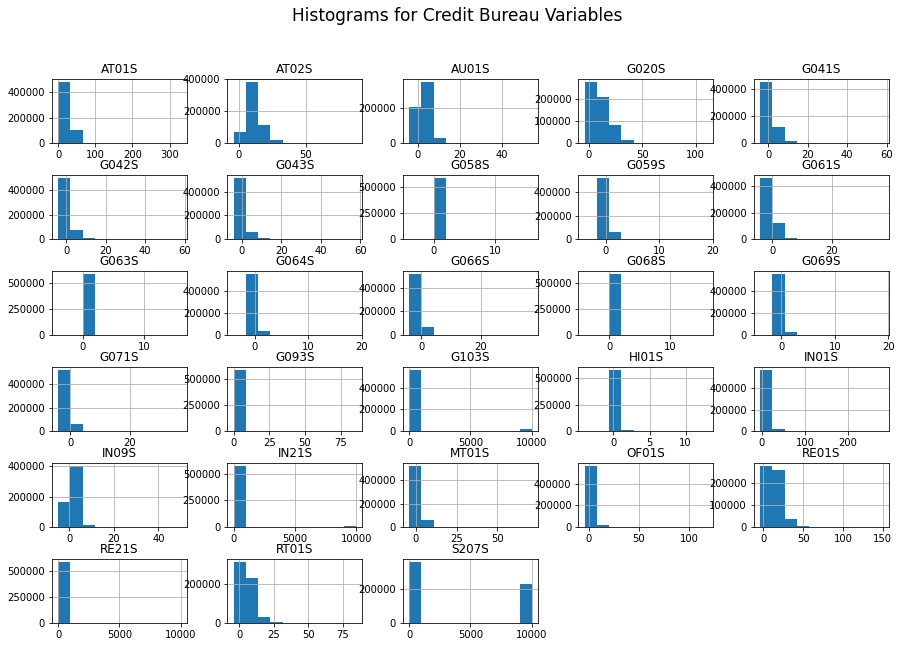

In [29]:
df_listings[sorted(tu_cols)].hist(figsize=(15, 10))
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Histograms for Credit Bureau Variables', size=17)
plt.show()

Below is a summary of each Transunion column including the description, valid values and special values.

| Column | Description | Valid Values | Special Values |
| ------ | ----------- | ------------ | --------------
| AT01S  | Number of trades | 0-999 | NONE |
| AT02S  | Number of open trades | 0-999 | -4 |
| AU01S  | Number of auto trades | 0-999 | -4 |
| G020S  | Number of trades with maximum delinquency of 30 days past due in past 24 months | 0-999 | -2, -4 |
| G041S  | Number of trades 30 or more days past due ever | 0-999 | -4 |
| G042S  | Number of trades 60 or more days past due ever | 0-999 | -4 |
| G043S  | Number of trades 90 or more days past due ever | 0-999 | -4 |
| G058S  | Number of trades 30 or more days past due in past 6 months | 0-999 | -4 |
| G059S  | Number of trades 30 or more days past due in past 12 months | 0-999 | -4 |
| G061S  | Number of trades 30 or more days past due in past 24 months | 0-999 | -4 |
| G063S  | Number of trades 60 or more days past due in past 6 months | 0-999 | -4 |
| G064S  | Number of trades 60 or more days past due in past 12 months | 0-999 | -4 |
| G066S  | Number of trades 60 or more days past due in past 24 months | 0-999 | -4 |
| G068S  | Number of trades 90 or more days past due in past 6 months | 0-999 | -4 |
| G069S  | Number of trades 90 or more days past due in past 12 months | 0-999 | -4 |
| G071S  | Number of trades 90 or more days past due in past 24 months | 0-999 | -4 |
| G093S  | Number of public records | 0-999 | NONE |
| G103S  | Months since most recent credit inquiry | 0-999 | -1,-4 |
| HI01S  | Number of home equity loan trades | 0-999 | -4 |
| IN01S  | Number of installment trades | 0-999 | -4 |
| IN09S  | Number of installment trades opened in past 24 months | 0-999 | -1,-4,-5 |
| IN21S  | Months since most recent installment trade opened | 0-999 | -1,-4,-5 |
| MT01S  | Number of mortgage trades | 0-999 | -4 |
| OF01S  | Number of credit union trades | 0-999 | -4 |
| RE01S  | Number of revolving trades | 0-999 | -4 |
| RE21S  | Months since most recent revolving trade opened | 0-999 | -1,-4,-5 |
| RT01S  | Number of retail trades | 0-999 | -4 |
| S207S  | Months since most recent public record bankruptcy | 0-999 | -1,-4 |

Below is the descriptions for the special values.

| Special Value | Description |
| ------ | ----------- |
| -1  | No trades this type |
| -2  | Not verified in time period |
| -4  | No trades on file |
| -5  | Cannot calculate (required data for calculation is missing) |

Based on the valid value ranges for the Transunion credit bureau fields, `G103S`, `IN21S` and `S207S` appear to have invalid values.  These are all "Months since" variables as well.

In [30]:
df_listings[sorted(tu_cols)].describe()

,AT01S,AT02S,AU01S,G020S,G041S,G042S,G043S,G058S,G059S,G061S,G063S,G064S,G066S,G068S,G069S,G071S,G093S,G103S,HI01S,IN01S,IN09S,IN21S,MT01S,OF01S,RE01S,RE21S,RT01S,S207S
count,584894.000000,584871.000000,584823.000000,584823.000000,584823.000000,584823.000000,584894.000000,584871.000000,584871.000000,584871.000000,584823.000000,584871.000000,584871.000000,584823.000000,584823.000000,584823.000000,584894.000000,584823.000000,584871.000000,584871.000000,584871.000000,584823.000000,584894.000000,584823.000000,584822.000000,584822.000000,584822.000000,584869.000000
mean,22.567356,11.277612,2.841479,9.418747,1.640493,1.077822,0.932350,0.073250,0.140658,0.367001,0.048495,0.081623,0.204030,0.046274,0.075407,0.178707,0.228558,303.294952,0.098069,7.262615,1.517962,229.708038,1.410343,1.486793,13.618802,13.222165,5.193702,3866.905762
std,12.087972,5.817068,2.595054,9.739706,2.544931,2.152208,2.027446,0.328529,0.489264,0.973970,0.278584,0.389863,0.768144,0.272948,0.377694,0.727068,0.632762,1696.860596,0.365584,6.712600,1.656371,1427.248291,1.683703,2.736024,8.163445,30.695169,4.527761,4864.256836
min,0.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,0.000000,-4.000000,-4.000000,-4.000000,-5.000000,-5.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000
25%,14.000000,7.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,3.000000,0.000000,6.000000,0.000000,0.000000,8.000000,4.000000,2.000000,-4.000000
50%,21.000000,10.000000,2.000000,8.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,5.000000,1.000000,12.000000,1.000000,0.000000,12.000000,8.000000,4.000000,-4.000000
75%,29.000000,14.000000,4.000000,15.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,0.000000,10.000000,2.000000,25.000000,2.000000,2.000000,18.000000,16.000000,7.000000,9999.000000
max,330.000000,88.000000,54.000000,111.000000,58.000000,58.000000,58.000000,16.000000,19.000000,37.000000,16.000000,19.000000,37.000000,16.000000,19.000000,37.000000,86.000000,9999.000000,13.000000,281.000000,50.000000,9999.000000,71.000000,118.000000,150.000000,9999.000000,85.000000,9999.000000


In [31]:
# Check to see which Experian column was mapped to Transunion
cb_check_cols = ['G103S', 'IN21S', 'S207S']
{k: v for k, v in cb_field_match.items() if v in cb_check_cols}

{'all790': 'S207S', 'all805': 'G103S', 'iln702': 'IN21S'}

The max values for `G103S`, `IN21S` and `S207S` are 9999.  In an earlier step we mapped Experian credit bureau fields to the equivalent match for Transunion.  Further inspection of the Experian API metadata shows that the 9999 is actually the default value with valid values between 0-9998.

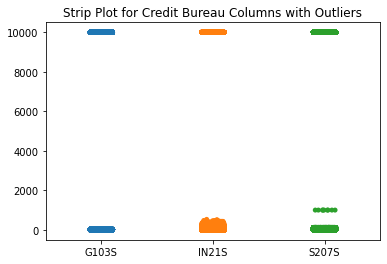

In [32]:
sns.stripplot(data=df_listings[cb_check_cols])
plt.title('Strip Plot for Credit Bureau Columns with Outliers')
plt.show()

In [33]:
# Review most common special value usage for these columns
cb_check_dict = {}
for col in cb_check_cols:
    col_dict = {}
    vc = df_listings[col][(df_listings[col] < 0) | (df_listings[col] > 999)].value_counts()
    for i in vc.index:
        col_dict[i] = vc[i]
    cb_check_dict[col] = col_dict
cb_check_dict

{'G103S': {-4.0: 26682, 9999.0: 17380},
 'IN21S': {-1.0: 12988, 9999.0: 12217, -4.0: 17, -5.0: 2},
 'S207S': {-4.0: 298547, 9999.0: 225882, -1.0: 10256}}

-4 will be used to replace 9999 for `G103S` and `S207S` and -1 will be used to replace 9999 for `IN21S`.

In [34]:
df_listings.describe(include=['O'])

,prosper_rating,fico_score,income_verifiable,employment_status_description,occupation,borrower_state,co_borrower_application
count,585087,266164,585087,585087,548899,585087,585087
unique,7,13,2,7,73,50,2
top,C,680-699,True,Employed,Other,CA,False
freq,150476,54844,580067,495486,125795,82003,584957


`posper_rating` is a proprietary rating developed by Prosper that quantifies the level of the listings risk.
The valid values are:

AA<br /> 
A<br /> 
B<br /> 
C<br /> 
D<br /> 
E<br /> 
HR<br /> 

AA is highest rating and HR is the lowest rating.  The field has 7 unique valies with no blanks.

`fico_score` has 255,117 blanks and the score is binned in ranges.  This field will be dropped.  `occupation` has 36,188 blanks and will be replaced with "Unknown".

## 1.3 Data Cleaning

Data Cleaning TODO recap:
1. Remove listings that are not `listing_status` 6.
2. Replace blanks for `prosper_score` with 0.
3. Replace blanks for `months_employed`.
4. Replace blanks for all `prior_prosper_` fields with zero.
5. Drop `combined_dti_wprosper_loan` and `combined_stated_monthly_income` columns.
6. Review outliers for `stated_monthly_income`, `months_employed` and `dti_wprosper_loan` columns.
7. Replace invalid special values for `G103S`, `IN21S` and `S207S`.
8. Drop `fico_score` column.
9. Replace blank `occupation` values with "Unknown". 

Review blank values for all columns.

In [35]:
df_listings.isna().sum()

origination_month                                        0
chargeoff_amount                                         0
debt_sale_recovery                                       0
principal_paid                                           0
interest_paid                                            0
chargeoff                                                0
closed_month                                             0
listing_creation_date                                    0
loan_origination_date                                   78
listing_status                                           0
listing_amount                                           0
prosper_rating                                           0
lender_yield                                             0
borrower_rate                                            0
borrower_apr                                             0
listing_term                                             0
listing_monthly_payment                                 

In [36]:
# Select only rows with a Completed listing status
df_clean = df_listings[df_listings['listing_status'] == 6].copy()

In [37]:
df_clean['listing_status'].unique()

<IntegerArray>
[6]
Length: 1, dtype: Int16

Only Completed listings remain in the clean data.

In [38]:
# Replace blank prosper score with zero
df_clean['prosper_score'] = df_clean['prosper_score'].fillna(0)

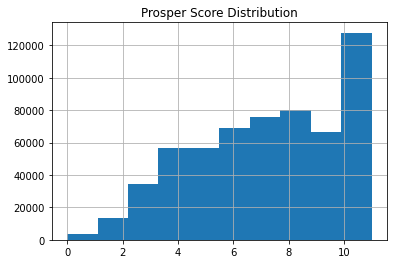

In [39]:
# Prosper Score distribution
df_clean['prosper_score'].hist()
plt.title('Prosper Score Distribution')
plt.show()

All Prosper Score values are valid between 1 and 10 as well as the 0 values that was used for the blanks.

In [40]:
# Replace months employed with median
df_clean['months_employed'] = df_clean['months_employed'].fillna(df_clean['months_employed'].median())

In [41]:
# Replace all prior prosper columns with zero
prior_prosper_cols = ['prior_prosper_loans_principal_borrowed','prior_prosper_loans_principal_outstanding',
                      'prior_prosper_loans_balance_outstanding','prior_prosper_loans_cycles_billed',
                      'prior_prosper_loans_ontime_payments','prior_prosper_loans_late_cycles',
                      'prior_prosper_loans_late_payments_one_month_plus','max_prior_prosper_loan',
                      'min_prior_prosper_loan','prior_prosper_loan_earliest_pay_off',
                      'prior_prosper_loans31dpd','prior_prosper_loans61dpd']

df_clean[prior_prosper_cols] = df_clean[prior_prosper_cols].fillna(0)

In [42]:
# Remove columns that have large amount of blanks
df_clean = df_clean.drop(['fico_score', 'combined_dti_wprosper_loan', 'combined_stated_monthly_income'], axis=1)

In [43]:
df_clean['dti_wprosper_loan'][df_clean['dti_wprosper_loan'] > 1].unique()

array([1.00e+06, 3.65e+00], dtype=float32)

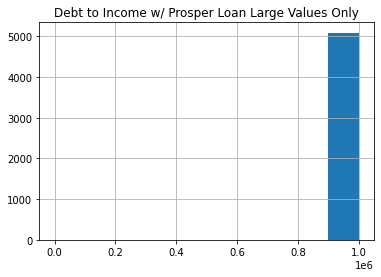

In [44]:
# Review dti_wprosper_loan > 1
df_clean['dti_wprosper_loan'][df_clean['dti_wprosper_loan'] > 1].hist()
plt.title('Debt to Income w/ Prosper Loan Large Values Only')
plt.show()

In [45]:
# Remove invalid values for dti_wprosper_loan
df_clean = df_clean[df_clean['dti_wprosper_loan'] != 1000000.0]
df_clean = df_clean[df_clean['dti_wprosper_loan'] != 3.65]

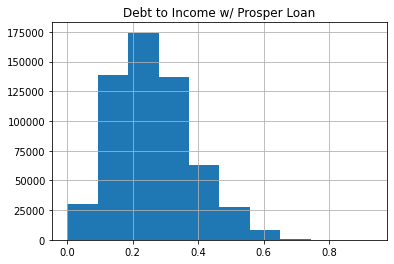

In [46]:
# Review histogram after removal
df_clean['dti_wprosper_loan'].hist()
plt.title('Debt to Income w/ Prosper Loan')
plt.show()

Debt to income ratio values are now all reasonable between 0 and 1 and no outliers.

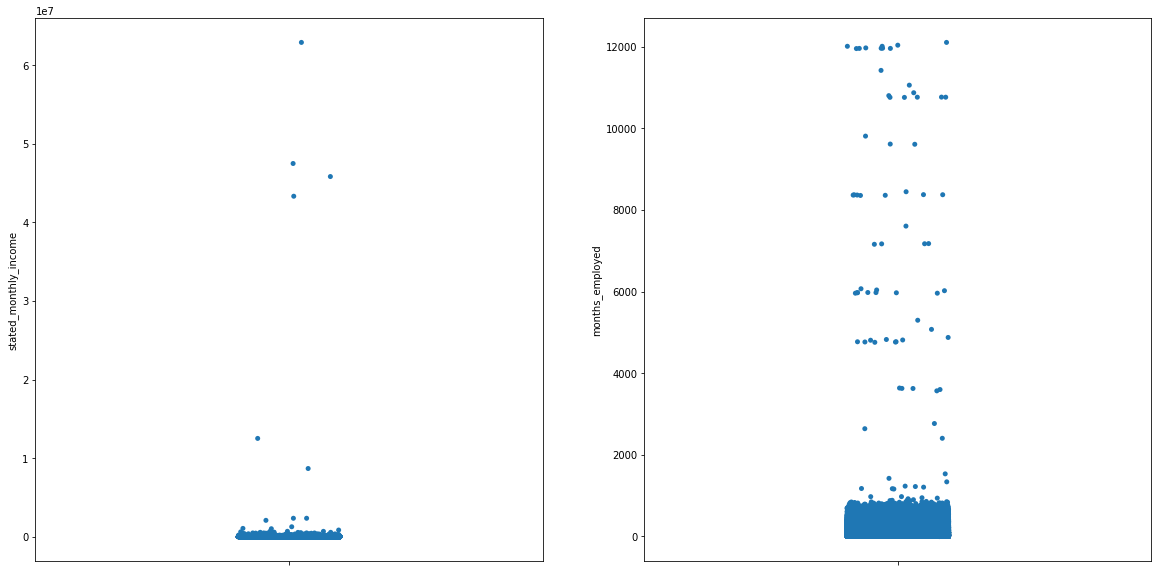

In [47]:
# Stripplots for monthly income and months employed columns
outlier_check = ['stated_monthly_income', 'months_employed']
fig, axes = plt.subplots(1,2, figsize=(20,10))
axes = axes.flatten()

for i, col in enumerate(outlier_check):
    ax = axes[i]
    sns.stripplot(y=col, data=df_clean, ax=ax)

There clearly are abnormal values for stated monthly income and months employed fields but for now going to leave these rows in the dataset and will be explored further in EDA.

In [48]:
# Replace blank occupation with Unknown
df_clean['occupation'] = df_clean['occupation'].fillna("Unknown")

In [49]:
df_clean['occupation'].unique()

array(['Professional', 'Retail Management', 'Sales - Commission', 'Other',
       'Nurse (RN)', 'Fireman', 'Civil Service', 'Accountant/CPA',
       'Military Enlisted', 'Skilled Labor', 'Executive', 'Truck Driver',
       'Computer Programmer', 'Profession that is not part of this list',
       'Teacher', "Nurse's Aide", 'Sales - Retail',
       'Food Service Management', 'Attorney', 'Social Worker',
       'Engineer - Electrical', 'Analyst', 'Administrative Assistant',
       'Medical Technician', 'Laborer', 'Food Service',
       'Engineer - Mechanical', 'Police Officer/Correction Officer',
       'Construction', 'Tradesman - Mechanic', 'Unknown', 'Scientist',
       'Tradesman - Electrician', 'Engineer - Chemical', 'Doctor',
       'Principal', 'Investor', 'Professor', 'Clerical',
       'Waiter/Waitress', 'Military Officer', 'Car Dealer', 'Pharmacist',
       'Judge', 'Nurse (LPN)', 'Postal Service', 'Landscaping',
       'Bus Driver', 'Clergy', 'Realtor', 'Student - College Senio

In [50]:
# Replace credit bureau with valid special values
df_clean['G103S'] = df_clean['G103S'].replace(9999.0, -4.0)
df_clean['IN21S'] = df_clean['IN21S'].replace(9999.0, -1.0)
df_clean['S207S'] = df_clean['S207S'].replace(9999.0, -4.0)

In [51]:
# Drop all remaining rows if any blanks
df_clean = df_clean.dropna()

In [52]:
# Final blank check
df_clean.isna().sum()

origination_month                                   0
chargeoff_amount                                    0
debt_sale_recovery                                  0
principal_paid                                      0
interest_paid                                       0
chargeoff                                           0
closed_month                                        0
listing_creation_date                               0
loan_origination_date                               0
listing_status                                      0
listing_amount                                      0
prosper_rating                                      0
lender_yield                                        0
borrower_rate                                       0
borrower_apr                                        0
listing_term                                        0
listing_monthly_payment                             0
prosper_score                                       0
income_range                

In [53]:
# Final duplicate check
df_clean = df_clean.drop_duplicates()

In [54]:
# Review final stats
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 579634 entries, 1053710 to 11868936
Data columns (total 70 columns):
 #   Column                                            Non-Null Count   Dtype         
---  ------                                            --------------   -----         
 0   origination_month                                 579634 non-null  float32       
 1   chargeoff_amount                                  579634 non-null  float32       
 2   debt_sale_recovery                                579634 non-null  float32       
 3   principal_paid                                    579634 non-null  float32       
 4   interest_paid                                     579634 non-null  float32       
 5   chargeoff                                         579634 non-null  int8          
 6   closed_month                                      579634 non-null  float32       
 7   listing_creation_date                             579634 non-null  datetime64[ns]
 8   loan_o

Final row count is 579,634 with no missing values.

In [55]:
# Save data to intermediate folder
intermediate_fn = r'..\data\intermediate\listings_clean.csv'
df_clean.to_csv(intermediate_fn)

In [56]:
clean_dt = df_clean.dtypes.apply(lambda x: x.name).to_dict()
dtypes_fn = r'..\data\intermediate\clean_dtypes.json'
with open(dtypes_fn, 'w') as f:
    json.dump(clean_dt, f)